## Overview

Spectral indices are core to many remote sensing analysis. In this section, we will learn how can we perform calculations using XArray.

We will take a single Sentinel-2 scene and calculate spectral indices like NDVI, MNDWI and SAVI.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install pystac-client odc-stac rioxarray dask jupyter-server-proxy

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import pystac_client
from odc import stac
import xarray as xr
import rioxarray as rxr

In [ ]:
from dask.distributed import Client
client = Client()  # set up local cluster on the machine
client

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:43679
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41323'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45735'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:44307 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44307
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:37432
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:45943 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45943
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:37440
INFO:distributed.scheduler:Receive client connection: Client-9646bf49-c17e-11f0-8db5-0242ac1c000c
INFO:distributed.core:Starting establish

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43679,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45943,Total threads: 1
Dashboard: http://127.0.0.1:37037/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:41323,


If you are running this notebook in Colab, you will need to create and use a proxy URL to see the dashboard running on the local server.

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    port_to_expose = 8787  # This is the default port for Dask dashboard
    print(output.eval_js(f'google.colab.kernel.proxyPort({port_to_expose})'))


https://8787-m-s-3l9rk32t0d95d-b.us-central1-0.prod.colab.dev


## Get a Sentinel-2 Scene

We define a location and time of interest to get some satellite imagery.

In [ ]:
latitude = 27.163
longitude = 82.608
year = 2023

In [ ]:
# Define a small bounding box around the chosen point
km2deg = 1.0 / 111
x, y = (longitude, latitude)
r = 1 * km2deg  # radius in degrees
bbox = (x - r, y - r, x + r, y + r)

Search the catalog for matching items.

In [ ]:
# Query the STAC Catalog
catalog = pystac_client.Client.open(
    'https://earth-search.aws.element84.com/v1')

search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    bbox=bbox,
    datetime=f'{year}',
    query={'eo:cloud_cover': {'lt': 30}, 's2:nodata_pixel_percentage': {'lt': 10}},
    sortby=[{'field': 'properties.eo:cloud_cover', 'direction': 'asc'}]

)
items = search.item_collection()

# Load to XArray
ds = stac.load(
    items,
    bands=['red', 'green', 'blue', 'nir', 'swir16'],
    resolution=10,
    chunks={},  # <-- use Dask
    groupby='solar_day',
    preserve_original_order=True
)

# Select the first scene
timestamp = pd.to_datetime(items[0].properties['datetime']).tz_convert(None)
scene = ds.sel(time=timestamp)
# Mask nodata values
scene = scene.where(scene != 0)
# Apply scale/offset
scale = 0.0001
offset = -0.1
scene = scene*scale + offset

## Visualize the Scene

To visualize our Dataset, we first convert it to a DataArray using the `to_array()` method. All the variables will be converted to a new dimension. Since our variables are image bands, we give the name of the new dimesion as band.


In [ ]:
scene_da = scene.to_array('band')

Rather than loading the entire scene into memory, we resample it to a lower resolution preview and render it.

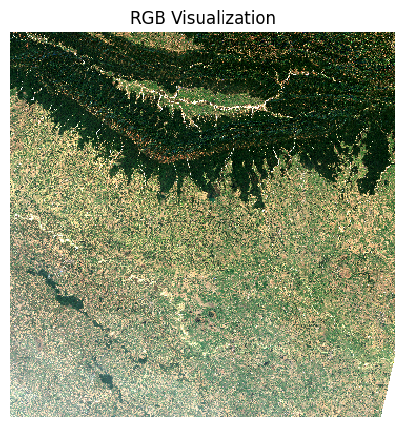

In [ ]:
preview = scene_da.rio.reproject(
    scene.rio.crs, resolution=300
)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
preview.sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
ax.set_aspect('equal')
plt.show()

We can also view a False Color Composite (FCC) with a different combination of spectral bands.

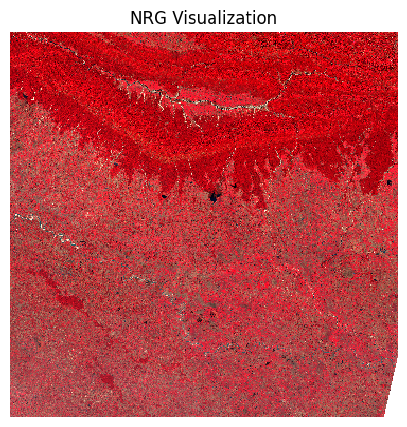

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
preview.sel(band=['nir', 'red', 'green']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('NRG Visualization')
ax.set_axis_off()
plt.show()

## Calculate Spectral Indices

The Normalized Difference Vegetation Index (NDVI) is calculated using the following formula:

`NDVI = (NIR - Red)/(NIR + Red)`

Where:
*   NIR = Near-Infrared band reflectance
*   Red = Red band reflectance

In [ ]:
red = scene_da.sel(band='red')
nir = scene_da.sel(band='nir')

ndvi = (nir - red)/(nir + red)
ndvi

<xarray.DataArray (y: 10980, x: 10980)> Size: 482MB
dask.array<truediv, shape=(10980, 10980), dtype=float32, chunksize=(10980, 10980), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 88kB 3.1e+06 3.1e+06 3.1e+06 ... 2.99e+06 2.99e+06
  * x            (x) float64 88kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
    spatial_ref  int32 4B 32644
    time         datetime64[ns] 8B 2023-12-24T05:21:10.640000

Let’s visualize the results.

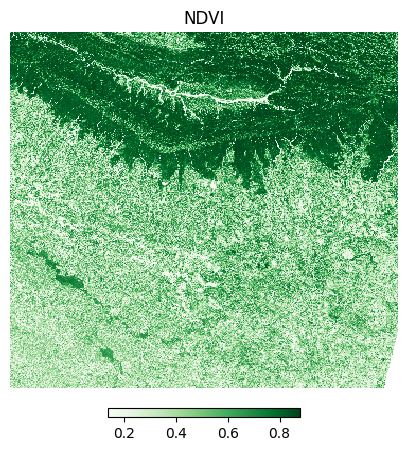

In [ ]:
ndvi_preview = ndvi.rio.reproject(
    ndvi.rio.crs, resolution=300
)
cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
ndvi_preview.plot.imshow(
    ax=ax,
    cmap='Greens',
    robust=True,
    cbar_kwargs=cbar_kwargs)
ax.set_title('NDVI')
ax.set_axis_off()
plt.show()

The Modified Normalized Difference Water Index (MNDWI) is calculated using the following formula:

`MNDWI = (Green - SWIR1)/(Green + SWIR1)`

Where:
*   Green = Green band reflectance
*   SWIR1 = Short-wave infrared band 1 reflectance

In [ ]:
green = scene_da.sel(band='green')
swir16 = scene_da.sel(band='swir16')
mndwi = (green - swir16)/(green + swir16)

The Soil Adjusted Vegetation Index (SAVI) is calculated using the following formula:


`SAVI = (1 + L) * ((NIR - Red)/(NIR + Red + L))`

Where:
*   NIR = Near-Infrared band reflectance
*   Red = Red band reflectance
*   L = Soil brightness correction factor (typically 0.5 for moderate vegetation)

In [ ]:
savi = 1.5 * ((nir - red) / (nir + red + 0.5))

## Save the Computed Indices

Rather than saving it to the temporary machine where Colab is running, we can save it to our own Google Drive. This will ensure the image will be available to us even after existing Google Colab.

Run the following cell to authenticate and mount the Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
drive_folder_root = 'MyDrive'
output_folder = 'data'
output_folder_path = os.path.join(
    '/content/drive', drive_folder_root, output_folder)

# Check if Google Drive is mounted
if not os.path.exists('/content/drive'):
    print("Google Drive is not mounted. Please run the cell above to mount your drive.")
else:
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

In [ ]:
files = {
    'ndvi.tif': ndvi,
    'mndwi.tif': mndwi,
    'savi.tif': savi
}

for file in files:
  output_path = os.path.join(output_folder_path, file)
  files[file].rio.to_raster(output_path, driver='COG')
  print(f'Saved {file} to {output_path}')

## Exercise

Apply a threshold to the NDVI values to create a binary raster.

Hint:

Xarray offers two different `where()` functions.

* [`xarray.DataArray.where`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html): Applies a condition and sets the non-matching values to NaN
* [`xarray.where`](https://docs.xarray.dev/en/stable/generated/xarray.where.html): Applies a condition and allows you to set both matching and non-matching values.

Use the `xr.where()` function to set matching values to 1 and non-matching values to 0.

In [ ]:
threshold = 0.5
# Create a new array 'vegeration' where all NDVI values
#  greater than the threshold is 1 and others are 0

In [ ]:
vegetation = xr.where(ndvi > threshold, 1, 0).astype('byte')

In [ ]:
vegetation.values

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

Let's visualize the `vegetation` data array using a custom colormap where 0 is white and 1 is green.

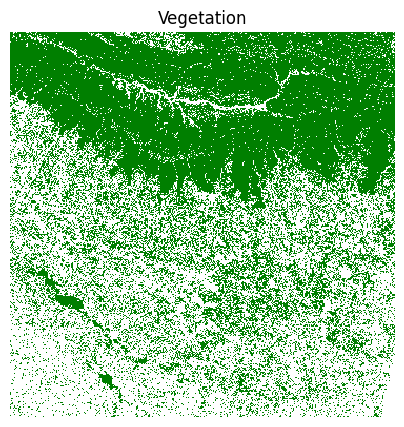

In [ ]:
# Resample for preview
vegetation_preview = vegetation.rio.reproject(
    vegetation.rio.crs, resolution=300
)

# Create a custom colormap: 0=white, 1=green
import matplotlib.colors as mcolors
colors = [(1, 1, 1), (0, 0.5, 0)]  # White to Green
cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
vegetation_preview.plot.imshow(
    ax=ax,
    cmap=cmap,
    add_colorbar=False)
ax.set_title('Vegetation')
ax.set_axis_off()
ax.set_aspect('equal')
plt.show()

We can also apply multiple thresholds.

| NDVI Range | Class |
| ---------- | ----- |
| < 0        | 1     |
| >=0 and < 0.5        | 2     |
| >=0.5        | 3     |

In [ ]:
vegetation_classes = xr.where(
    ndvi < 0, # Condition 1: ndvi < 0
    1,
    xr.where(
        ndvi > 0.5, # Condition 2: ndvi > 0.5
        3,
        2 # Else (0 <= ndvi <= 0.5)
    )
).astype('byte')
vegetation_classes

In [ ]:
vegetation_classes.values

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 2],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int8)